In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pickle
import os

In [2]:
file = os.path.join('extraction_svm.pkl')
with open(file, 'rb') as fichier : extraction_svm = pickle.load(fichier, encoding='latin1')

In [3]:
grid = extraction_svm['grid']
y_train0 = extraction_svm['y_train']
y_test0 = extraction_svm['y_test']
y_pred0 = extraction_svm['y_pred']
X_test0 = extraction_svm['X_test']
X_train0 = extraction_svm['X_train']
var = extraction_svm['var']

print(grid.best_params_, '-->', grid.best_score_)

{'C': 0.23378038720396177, 'gamma': 0.38233342215886723, 'kernel': 'rbf'} --> 0.8359167321876522


In [4]:
X_train, y_train = X_train0[:, :-1], y_train0
X_test, y_test = X_test0[:, :-1], y_test0

print(X_test0.shape, X_test.shape)

(2160, 16) (2160, 15)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 0.25555555555555554, 'kernel': 'linear'} --> 0.7915047362312329
[[0.79029166 0.78985735 0.79078962 0.79035531 0.79046389 0.79046389
  0.79035531 0.79150474 0.79046389 0.79024673]]


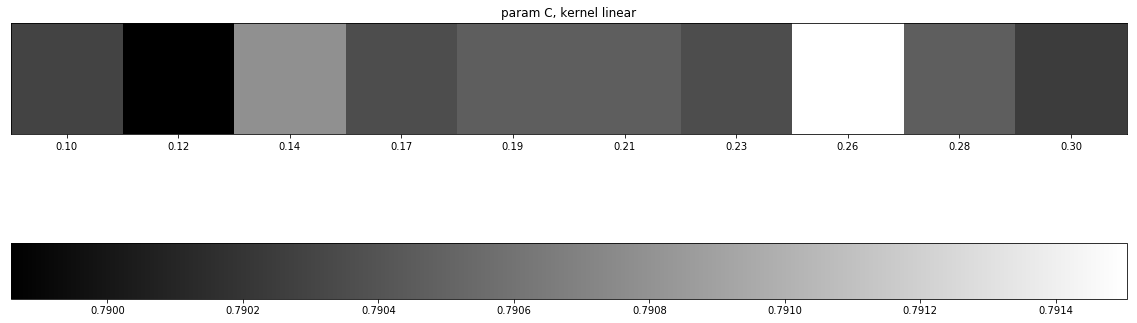

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#C_range = np.logspace(-5, 10., 32, base=2.)
C_range =  np.linspace(0.1, 0.3, 10)
tol = 1e-3 #, 1e-2, 1e-1]


param_grid = [{'kernel': ['linear'], 'C': C_range}]


grid = GridSearchCV(SVC(verbose=False, max_iter = -1, tol=tol, class_weight='balanced', probability=True),
                    param_grid, verbose=0, scoring='balanced_accuracy', n_jobs=1,) #cv=50, n_jobs=-1


X_train_ = np.zeros((len(X_train), 0))
X_train_ = np.hstack((X_train_, X_train))
grid.fit(X_train, y_train.ravel())

print(grid.best_params_, '-->', grid.best_score_)

means, stds = grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score']
    
scores_mean, scores_std = {}, {}
for i, (mean_score, std, params) in enumerate(zip(means, stds, grid.cv_results_['params'])):
    if i==0 :
        scores_mean[params['kernel']] = []
        scores_std[params['kernel']] = []
    
    scores_mean[params['kernel']].append(mean_score)
    scores_std[params['kernel']].append(std)

# draw heatmap of accuracy as a function of gamma and C

fig, ax = plt.subplots(1,1,figsize=(20,10))
scores = np.array(scores_mean[params['kernel']]).reshape((1, C_range.shape[0]))
print(scores)
im = ax.imshow(scores, interpolation='nearest', cmap=plt.cm.gray)#, vmin=0, vmax=1)

ax.set_xticks(range(0, len(C_range), 1))
plt.yticks([]);

ax.set_xticklabels(['%0.2f'%C_range[num] for num in range(0, len(C_range), 1)])

ax.set_title('param C, kernel '+params['kernel'])
fig.colorbar(im, ax=ax, pad=0.2, fraction=0.5, orientation='horizontal');

In [6]:
from sklearn.feature_selection import RFE

svc = SVC(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])

rfe = RFE(estimator=svc, n_features_to_select=1)
rfe.fit(X_train, y_train.ravel())
ranking = rfe.ranking_

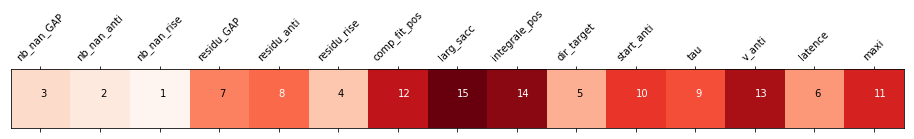

In [7]:
plt.matshow(ranking.reshape((1,15)), cmap=plt.cm.Reds)
for x in range(len(ranking)) :
    plt.text(x, -0.045, ranking[x], color="white" if ranking[x] > np.max(ranking)/2 else "black")
plt.xticks(range(len(var)), var, rotation=45)
plt.yticks([]);